## **Title: Sensitive Scanned Document Classification (Binary Model)**

**Problem Statement:** Predict if a scanned document contains sensitive information (Interested NERs : name, city, street, CPR)

**Data:** Dummy Sample, datapoints containing interested entities are marked as 1, others are marked as 0

**Business Technical Mapping:** The business problem can be mapped to a binary classification problem

**Latency Requirments:** None

**Metrics:** Accuracy (Not very reliable in this case as the data is imbalanced), ROC-AUC, Confusion Matrix

**Constraints:** Imbalanced dataset, data quality, less number of avilable data points 

In [1]:
# Import necessary libraries
import os
import joblib
import cv2
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import skimage.io
from tqdm import tqdm
import tensorflow as tf
from PIL import Image
import argparse
import os
import pandas as pd
from sklearn import preprocessing
import math
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
from random import shuffle
from keras.optimizers import Adam
import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

**Data Preparation**

In [3]:
import zipfile
with zipfile.ZipFile('dummy_sample.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [4]:
# Reading the dataset
data=pd.read_csv('/dummy_sample.csv')
data=data.head(3500)
data=data.fillna('NA')

In [6]:
# Creating directory structure for training data
os.mkdir('/content/Train')
os.mkdir('/content/Test')
os.mkdir('/content/Train/sensitive')
os.mkdir('/content/Test/sensitive')
os.mkdir('/content/Train/non-sensitive')
os.mkdir('/content/Test/non-sensitive')

In [ ]:
labels=[]
img_path=[]
dest_path=[]
labels_={0:'non-sensitive',1:'sensitive'}
for i in range(len(data)):
  img_name='/dummy_sample/images/'+data.iloc[i].Filename.split("\\")[-1]
  img_dest='/dummy_sample/images/'+labels_[data.iloc[i].sensitive]+'/'+data.iloc[i].Filename.split("\\")[-1]
  img_path.append(img_name)
  dest_path.append(img_dest)
  labels.append(data.iloc[i].sensitive)

data_final=pd.DataFrame(columns=['Imagepath','label','destpath'])
data_final['Imagepath']=img_path
data_final['label']=labels
data_final['destpath']=dest_path
data_final.head()

**Data Preparation/ Split Data**

In [8]:
# Split the dataset in to train and test, we are doing a stratified sampling such that the ratio of two classes remains same in train and test data

x_train,x_test,y_train,y_test=train_test_split(data_final['Imagepath'],data_final['label'],test_size=0.15,stratify=data_final['label'])

In [9]:
# Move the data in to proper folders for keras data generators
labels_={0:'non-sensitive',1:'sensitive'}
def move_data(data,y_data,type='train'):
    for i in range(len(y_data)):
        source_path=data[i]
        dest_path='/content/Train/'+labels_[y_data[i]]+'/'+data[i].split("/")[-1]
        if(type=='test'):
              dest_path='/content/Test/'+labels_[y_data[i]]+'/'+data[i].split("/")[-1]
        try:      
            shutil.move(source_path,dest_path)   
        except Exception as e:
            print(e)         

move_data(list(x_train),list(y_train),type='train')
move_data(list(x_test),list(y_test),type='test')       

**Exploratory Data Analysis**

In [10]:
# Data Overview
print("Number of data points in dataset", data_final.shape)
print("The attributes of data :", data_final.columns.values)
#Checking for None
data_final.isna().sum()

Number of data points in dataset (3500, 3)
The attributes of data : ['Imagepath' 'label' 'destpath']


Imagepath    0
label        0
destpath     0
dtype: int64

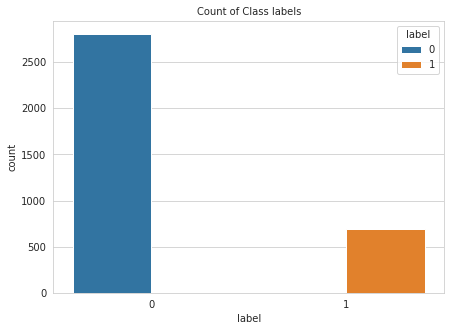

In [11]:
# Checking the data balance
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(7,5))
plt.title('Count of Class labels', fontsize=10)
sns.countplot(x='label',data=data_final,hue='label')
plt.show()

**Utility Methods for Modelling**

In [12]:
def eval_model(model,limit=500):
    """
   This function predicts the result of a candidate model
   test_generator : genertaor to evaluate
   model : candidate model
   limit: No of test samples to consider
    
    """
    batch_size=limit
    _,val_generator=get_data_generator(train_path,test_path,batch_size)
    x,y=val_generator.next()
    y_pred=[]
    y_true=[]
    count=0
    for i in range(len(x)):
        pred=model.predict(np.expand_dims(x[i], axis=0))
        predicted_y=np.argmax(pred)
        y_pred.append(predicted_y)
        y_true.append(np.argmax(y[i]))
    return y_pred,y_true    



def get_acc_f1_precision_recall(y_pred,y_true):
    """
    This function evaluate the performance(accuracy,f1-score,precision,recall,confusion matrix of the network).
    """
    acc=np.round(accuracy_score(y_pred,y_true),3)
    f1=np.round(f1_score(y_pred,y_true,average='micro'),3)
    precision=np.round(precision_score(y_pred,y_true),3)
    recall=np.round(recall_score(y_pred,y_true),3)
    print('Accuracy:',acc)
    print('F1 Score:',f1)
    print('Precision:',precision)
    print('Recall:',recall)
    return acc,f1,precision,recall   

In [14]:
def get_data_generator(train_dir,test_dir,batch_size=50):
    """
    method to generate training batches on the go, along with data augmentation
    """
    # Using Data Augmentation for better variance
    train_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=13,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2)

    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

    val_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=13,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2)

    val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")
    return train_generator,val_generator

In [15]:
def run_model(model):
    """
    Method to retrain models using transfer learning
    """
    for layer in model.layers:
        layer.trainable=True
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    # creating the final model 
    model_final = Model(model.input, predictions)
    # compile the model 
    print('[Info] Compiling the Model')
    model_final.compile(loss = "binary_crossentropy", optimizer =Adam(lr=0.0001), metrics=["accuracy"])
    print('[Info] Model Training Started')
    history=model_final.fit_generator(
    train_generator,
    steps_per_epoch =500/batch_size,
    epochs=20,validation_data=val_generator,validation_steps=math.ceil(200//(batch_size)),class_weight=class_weight,
    callbacks=[mcp_save,es,reduce_lr])      
    return model_final,history


In [16]:
def get_roc_auc(y_pred,y_true):
    """
    Method to calculate and plot ROC-AUC
    """
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='ROC_AUC (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [17]:
def plot_confusion_matrix(test_y, predict_y):
     
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    """
    This function will plot the consusion matrix.
    """
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [int(i) for i in range(2)]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(7,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(7,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(7,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [18]:
def visualize_training(history):
    """
    Method to visualize training 
    """
    plt.figure(1)
    plt.plot(history.history['loss'], label='Loss (training data)')
    plt.plot(history.history['val_loss'], label='Loss (validation data)')
    plt.title('Epochs vs Binary crossentropy')
    plt.ylabel('Loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    plt.figure(2)
    plt.plot(history.history['accuracy'], label='Accurcy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Epochs vs Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

In [19]:
# Method to check model performance
def check_model_performance(model,limit=500):
    print("-"*50, "Model Performance", "-"*50)
    # ROC AUC
    y_pred,y_true=eval_model(model,limit)
    print("-"*50, "Metrics", "-"*50)
    get_acc_f1_precision_recall(y_pred,y_true)
    get_roc_auc(y_pred,y_true)  
    plot_confusion_matrix(y_true, y_pred)

***Training Configuration***

In [20]:
img_width, img_height = 300,300
batch_size = 50
epochs = 10
num_classes=2
samples_per_epoch =500

In [21]:
# Generating Training and Validation batches
train_path='/content/Train'
test_path='/content/Test'
train_generator,val_generator=get_data_generator(train_path,test_path)

Found 2975 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


In [22]:
# Configure the callbacks
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
mcp_save = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='acc', mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5,restore_best_weights=True)

In [23]:
# Assigning class weights, more weightage to class 1 

class_weight = {0: 0.25,
                1: 0.75}

**Training Approach**

*   To address the imbalancd dataset problem, we are dividing the dataset in to train and test using stratified sampling to maintain the ratio between two classes in the train and test samples. We are giving more importance to the minority class by introducing class weights
*   For training we are first creating a random model as baseline. Any model that performs better (in terms of ROC-AUC Score, Accuracy) than the random model will be considered as a valid candidate model
*   We will use transfer learning to train the models(ImageNet weight) and validate the performance using SOTA image classification models (i.e. VGG16, Vgg16, XceptionNet, InceptionResNetV2 etc)
*   We are using dropouts to avoid overfitting and also the earlystopping callback to stop the training early if the model tends to overfitt during the training epochs
* We will reduce learning rate when a metric has stopped improving.We are reducing the learning rate by a factor of 2 once learning stagnates. This callback monitors validation loss and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.








**Random Model**

-------------------------------------------------- Metrics --------------------------------------------------
Accuracy: 0.491
F1 Score: 0.491
Precision: 0.471
Recall: 0.188


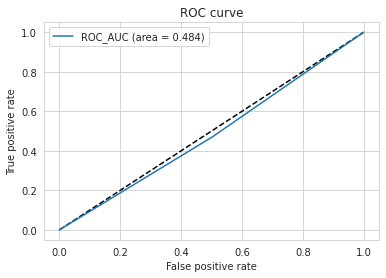

-------------------------------------------------- Confusion matrix --------------------------------------------------


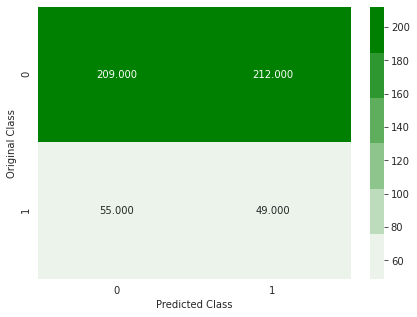

-------------------------------------------------- Precision matrix --------------------------------------------------


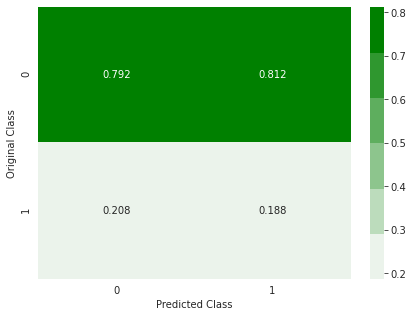

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


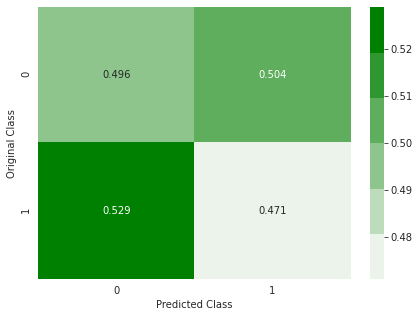

Sum of rows in precision matrix [1. 1.]


In [24]:
from random import randint
y_true=val_generator.labels
y_pred=[randint(0,1) for i in range(len(y_true))]
print("-"*50, "Metrics", "-"*50)
get_acc_f1_precision_recall(y_pred,y_true)
get_roc_auc(y_pred,y_true)  
plot_confusion_matrix(y_true, y_pred)

**VGG16**

In [33]:
model =keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)
model_vgg16,history_vgg16=run_model(model)

58892288/58889256 [==============================] - 0s 0us/step
[Info] Compiling the Model
[Info] Model Training Started


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
10/10 [==============================] - 57s 6s/step - loss: 0.2541 - accuracy: 0.7628 - val_loss: 0.5947 - val_accuracy: 0.7750
Epoch 2/20
10/10 [==============================] - 52s 5s/step - loss: 0.2693 - accuracy: 0.6801 - val_loss: 0.6347 - val_accuracy: 0.5450
Epoch 3/20
10/10 [==============================] - 53s 5s/step - loss: 0.2423 - accuracy: 0.6326 - val_loss: 0.6054 - val_accuracy: 0.8050
Epoch 4/20
10/10 [==============================] - 53s 5s/step - loss: 0.2290 - accuracy: 0.8037 - val_loss: 0.6268 - val_accuracy: 0.7950
Epoch 5/20
10/10 [==============================] - 54s 5s/step - loss: 0.2268 - accuracy: 0.7708 - val_loss: 0.5643 - val_accuracy: 0.8550
Epoch 6/20
10/10 [==============================] - 53s 5s/step - loss: 0.2267 - accuracy: 0.8116 - val_loss: 0.5883 - val_accuracy: 0.7650
Epoch 7/20
10/10 [==============================] - 54s 5s/step - loss: 0.2181 - accuracy: 0.7870 - val_loss: 0.5345 - val_accuracy: 0.7800
Epoch 8/20
10/10 [==

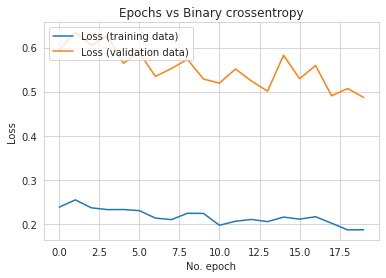

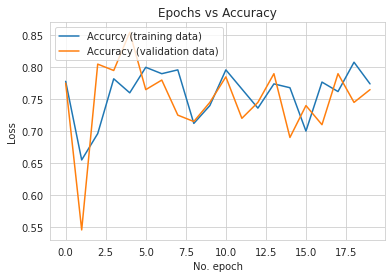

In [34]:
visualize_training(history_vgg16)

-------------------------------------------------- Model Performance --------------------------------------------------
Found 2975 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


-------------------------------------------------- Metrics --------------------------------------------------
Accuracy: 0.724
F1 Score: 0.724
Precision: 0.636
Recall: 0.382


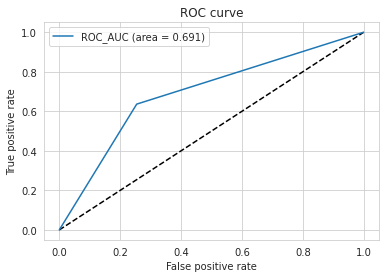

-------------------------------------------------- Confusion matrix --------------------------------------------------


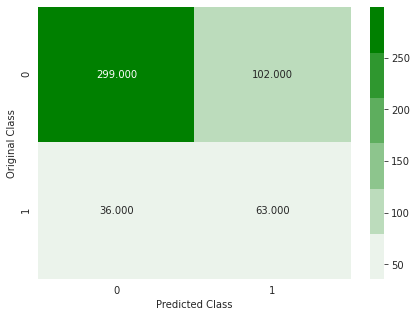

-------------------------------------------------- Precision matrix --------------------------------------------------


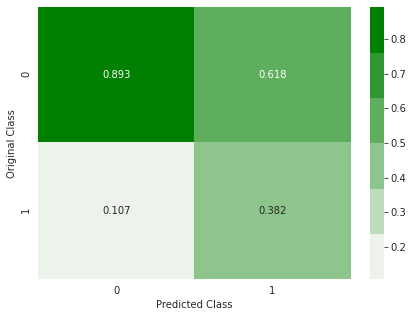

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


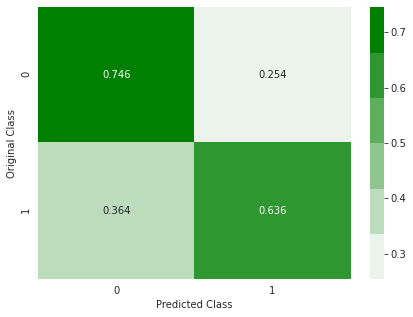

Sum of rows in precision matrix [1. 1.]


In [35]:
check_model_performance(model_vgg16,500)

**VGG19**

In [25]:

model =keras.applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)
model_vgg19,history_vgg19=run_model(model)

80142336/80134624 [==============================] - 0s 0us/step
[Info] Compiling the Model
[Info] Model Training Started


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
10/10 [==============================] - 70s 6s/step - loss: 0.2822 - accuracy: 0.5405 - val_loss: 0.5979 - val_accuracy: 0.8200
Epoch 2/20
10/10 [==============================] - 55s 6s/step - loss: 0.2185 - accuracy: 0.8020 - val_loss: 0.6346 - val_accuracy: 0.7350
Epoch 3/20
10/10 [==============================] - 55s 6s/step - loss: 0.2295 - accuracy: 0.7485 - val_loss: 0.6402 - val_accuracy: 0.7150
Epoch 4/20
10/10 [==============================] - 56s 6s/step - loss: 0.2364 - accuracy: 0.6981 - val_loss: 0.6203 - val_accuracy: 0.7750
Epoch 5/20
10/10 [==============================] - 56s 6s/step - loss: 0.2444 - accuracy: 0.7175 - val_loss: 0.5995 - val_accuracy: 0.7900
Epoch 6/20
10/10 [==============================] - 55s 6s/step - loss: 0.2312 - accuracy: 0.7161 - val_loss: 0.5859 - val_accuracy: 0.7850
Epoch 7/20
10/10 [==============================] - 55s 6s/step - loss: 0.2218 - accuracy: 0.7714 - val_loss: 0.5175 - val_accuracy: 0.7900
Epoch 8/20
10/10 [==

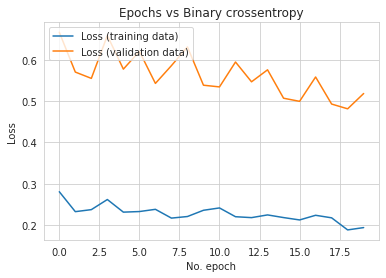

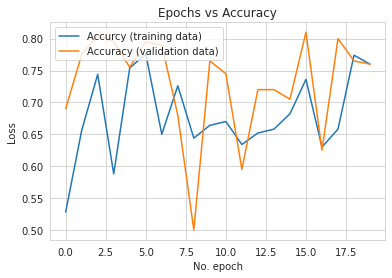

In [ ]:
visualize_training(history_vgg19)

-------------------------------------------------- Model Performance --------------------------------------------------
Found 2975 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


-------------------------------------------------- Metrics --------------------------------------------------
Accuracy: 0.798
F1 Score: 0.798
Precision: 0.596
Recall: 0.492


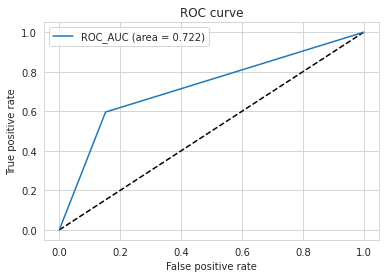

-------------------------------------------------- Confusion matrix --------------------------------------------------


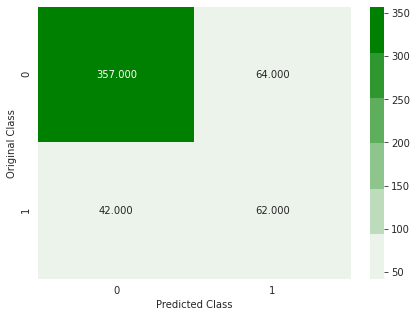

-------------------------------------------------- Precision matrix --------------------------------------------------


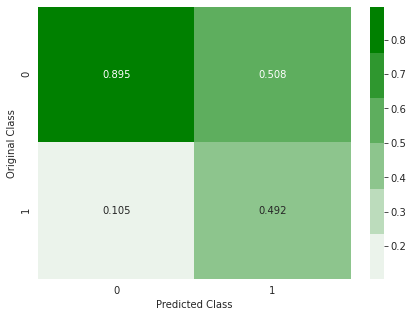

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


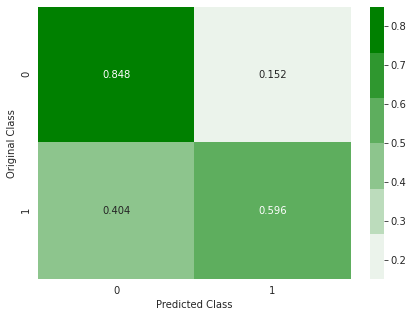

Sum of rows in precision matrix [1. 1.]


In [27]:
check_model_performance(model_vgg19,525)

**Xception**

In [28]:

model =keras.applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)
model_xception,history_xception=run_model(model)

[Info] Compiling the Model
[Info] Model Training Started


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
10/10 [==============================] - 63s 6s/step - loss: 0.3355 - accuracy: 0.5583 - val_loss: 0.6517 - val_accuracy: 0.7750
Epoch 2/20
10/10 [==============================] - 55s 6s/step - loss: 0.2109 - accuracy: 0.8109 - val_loss: 0.6278 - val_accuracy: 0.7600
Epoch 3/20
10/10 [==============================] - 55s 6s/step - loss: 0.1839 - accuracy: 0.7917 - val_loss: 0.5964 - val_accuracy: 0.7950
Epoch 4/20
10/10 [==============================] - 55s 6s/step - loss: 0.1875 - accuracy: 0.7626 - val_loss: 0.4816 - val_accuracy: 0.8250
Epoch 5/20
10/10 [==============================] - 56s 6s/step - loss: 0.1699 - accuracy: 0.8328 - val_loss: 0.4403 - val_accuracy: 0.8100
Epoch 6/20
10/10 [==============================] - 55s 6s/step - loss: 0.1423 - accuracy: 0.8404 - val_loss: 0.4685 - val_accuracy: 0.7900
Epoch 7/20
10/10 [==============================] - 56s 6s/step - loss: 0.1471 - accuracy: 0.8195 - val_loss: 0.3753 - val_accuracy: 0.8400
Epoch 8/20
10/10 [==

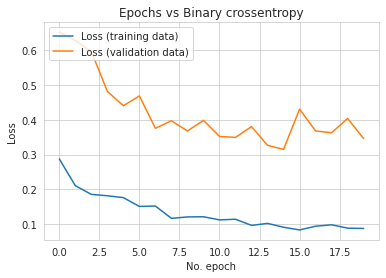

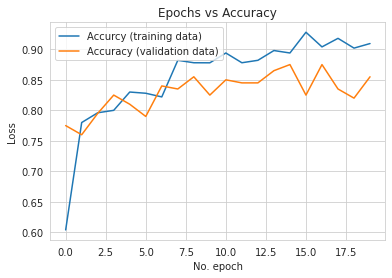

In [29]:
visualize_training(history_xception)

-------------------------------------------------- Model Performance --------------------------------------------------
Found 2975 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


-------------------------------------------------- Metrics --------------------------------------------------
Accuracy: 0.869
F1 Score: 0.869
Precision: 0.673
Recall: 0.667


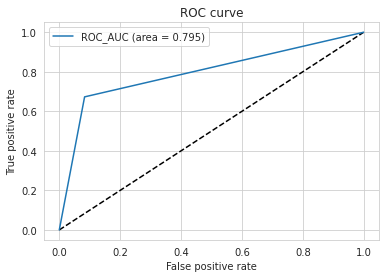

-------------------------------------------------- Confusion matrix --------------------------------------------------


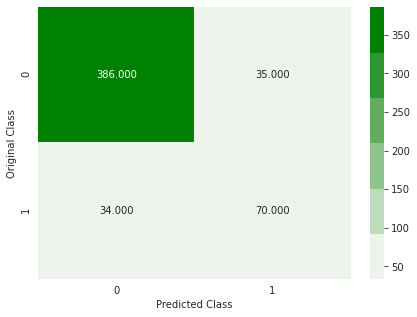

-------------------------------------------------- Precision matrix --------------------------------------------------


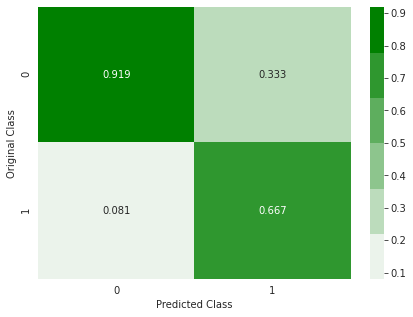

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


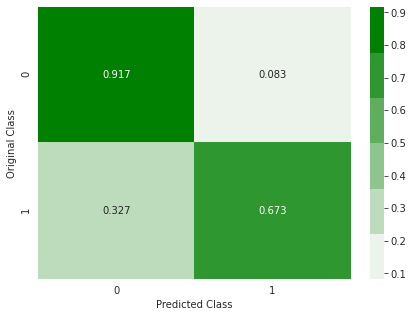

Sum of rows in precision matrix [1. 1.]


In [30]:
check_model_performance(model_xception,525)

**InceptionResNetv2**

In [ ]:

model =keras.applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3),)
model_inceptionResNet,history_inceptionResNet=run_model(model)

219062272/219055592 [==============================] - 1s 0us/step
[Info] Compiling the Model
[Info] Model Training Started


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
10/10 [==============================] - 72s 5s/step - loss: 0.2872 - accuracy: 0.6476 - val_loss: 0.6685 - val_accuracy: 0.5650
Epoch 2/20
10/10 [==============================] - 48s 5s/step - loss: 0.1823 - accuracy: 0.8472 - val_loss: 0.5086 - val_accuracy: 0.8200
Epoch 3/20
10/10 [==============================] - 48s 5s/step - loss: 0.1887 - accuracy: 0.7790 - val_loss: 0.5183 - val_accuracy: 0.8100
Epoch 4/20
10/10 [==============================] - 49s 5s/step - loss: 0.1802 - accuracy: 0.8343 - val_loss: 0.4311 - val_accuracy: 0.8100
Epoch 5/20
10/10 [==============================] - 50s 5s/step - loss: 0.1828 - accuracy: 0.8522 - val_loss: 0.4482 - val_accuracy: 0.8450
Epoch 6/20
10/10 [==============================] - 50s 5s/step - loss: 0.1601 - accuracy: 0.8447 - val_loss: 0.4690 - val_accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 49s 5s/step - loss: 0.1323 - accuracy: 0.8784 - val_loss: 0.4281 - val_accuracy: 0.8000
Epoch 8/20
10/10 [==

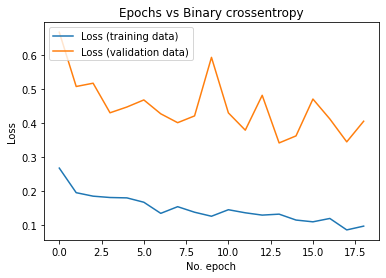

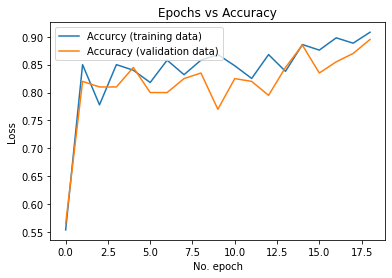

In [ ]:
visualize_training(history_inceptionResNet)

-------------------------------------------------- Model Performance --------------------------------------------------
Found 2975 images belonging to 2 classes.
Found 525 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


-------------------------------------------------- Metrics --------------------------------------------------
Accuracy: 0.85
F1 Score: 0.85
Precision: 0.548
Recall: 0.64


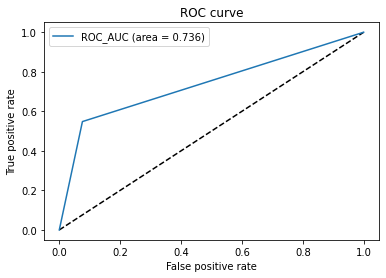

-------------------------------------------------- Confusion matrix --------------------------------------------------


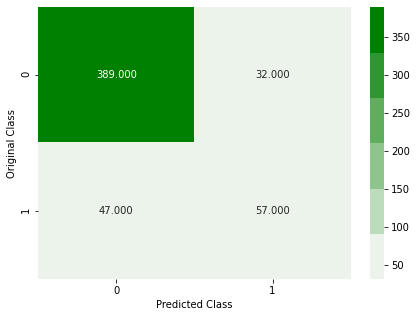

-------------------------------------------------- Precision matrix --------------------------------------------------


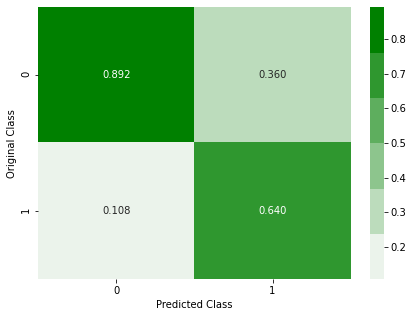

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


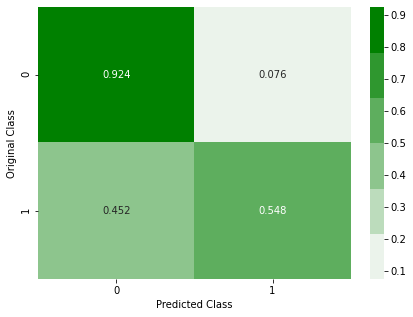

Sum of rows in precision matrix [1. 1.]


In [ ]:
check_model_performance(model_inceptionResNet,525)

**Summary**

In [38]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['Model','Accuracy','ROC-AUC','F1-Score','Precision','Recall']
x.add_row(['Random','0.49','0.48','0.49','0.47','0.18'])
x.add_row(['Vgg16','0.72','0.69','0.72','0.63','0.38'])
x.add_row(['Vgg19','0.79','0.72','0.79','0.59','0.49'])
x.add_row(['Xception','0.87','0.79','0.87','0.67','0.66'])
x.add_row(['InceptionResNetV2','0.85','0.74','0.85','0.59','0.64'])


print(x)  

+-------------------+----------+---------+----------+-----------+--------+
|       Model       | Accuracy | ROC-AUC | F1-Score | Precision | Recall |
+-------------------+----------+---------+----------+-----------+--------+
|       Random      |   0.49   |   0.48  |   0.49   |    0.47   |  0.18  |
|       Vgg16       |   0.72   |   0.69  |   0.72   |    0.63   |  0.38  |
|       Vgg19       |   0.79   |   0.72  |   0.79   |    0.59   |  0.49  |
|      Xception     |   0.87   |   0.79  |   0.87   |    0.67   |  0.66  |
| InceptionResNetV2 |   0.85   |   0.74  |   0.85   |    0.59   |  0.64  |
+-------------------+----------+---------+----------+-----------+--------+
